## Data Loading and Merging Process

This section outlines the steps to load and merge data until we have the final datasets: `ark_data`, `isle_data`, and `nms_data`. We begin by bringing in pickled data, which contains a dictionary of DataFrames. Specific DataFrames, such as `ark_update_data`, are accessed and subsequently merged to form the comprehensive datasets required for analysis.

In [1]:
# Install darts library
!pip install darts

In [2]:
import pandas as pd
from pathlib import Path
from darts import TimeSeries
import numpy as np
import pickle

# Define the path to the pickles directory
PICKLES_PATH = Path('pickles')

def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

# Load all pickled data
ark_players = load_pickle(PICKLES_PATH / 'ark_players.pkl')
ark_reviews = load_pickle(PICKLES_PATH / 'ark_reviews.pkl')
ark_updates = load_pickle(PICKLES_PATH / 'ark_updates_analysis.pkl')

isle_merged = load_pickle(PICKLES_PATH / 'isle_merged.pkl')
isle_reviews = load_pickle(PICKLES_PATH / 'isle_reviews.pkl')

nms_players = load_pickle(PICKLES_PATH / 'noman_players.pkl')
nms_reviews = load_pickle(PICKLES_PATH / 'nms_reviews.pkl')
nms_updates = load_pickle(PICKLES_PATH / 'nms_updates_analysis.pkl')

In [3]:
#Checking the data that got brought in before merging to one for DARTS
def explore_data(data, name, level=0):
    indent = "  " * level
    print(f"\n{indent}{'='*50}")
    print(f"{indent}{name} Data Exploration")
    print(f"{indent}{'='*50}")
    
    if isinstance(data, pd.DataFrame):
        print(f"{indent}Type: pandas DataFrame")
        print(f"{indent}Shape: {data.shape}")
        print(f"{indent}Columns:")
        for col in data.columns:
            print(f"{indent}- {col}")
        print(f"{indent}Data Types:")
        print(data.dtypes)
        print(f"{indent}First few rows:")
        print(data.head())
        print(f"{indent}Descriptive Statistics:")
        print(data.describe(include='all'))
    
    elif isinstance(data, dict):
        print(f"{indent}Type: Dictionary")
        print(f"{indent}Number of keys: {len(data)}")
        print(f"{indent}Keys:")
        for key, value in data.items():
            print(f"{indent}- {key}")
            if isinstance(value, (pd.DataFrame, dict, list, np.ndarray)):
                explore_data(value, f"{name} - {key}", level+1)
            else:
                print(f"{indent}  Value: {value}")
    
    elif isinstance(data, list):
        print(f"{indent}Type: List")
        print(f"{indent}Length: {len(data)}")
        if len(data) > 0:
            print(f"{indent}First element type: {type(data[0])}")
            if len(data) > 5:
                print(f"{indent}First 5 elements: {data[:5]}")
            else:
                print(f"{indent}All elements: {data}")
    
    elif isinstance(data, np.ndarray):
        print(f"{indent}Type: NumPy Array")
        print(f"{indent}Shape: {data.shape}")
        print(f"{indent}Data Type: {data.dtype}")
        if data.ndim == 1 and len(data) <= 10:
            print(f"{indent}Values: {data}")
        elif data.ndim == 2 and data.shape[0] <= 5 and data.shape[1] <= 5:
            print(f"{indent}Values:\n{data}")
        else:
            print(f"{indent}Array is too large to display fully.")
    
    else:
        print(f"{indent}Type: {type(data)}")
        print(f"{indent}Value: {data}")
    
    print(f"{indent}{'='*50}\n")

# Explore each dataset before merging
print("Exploring datasets before merging:")

print("\nARK Datasets:")
explore_data(ark_players, "ARK Players")
explore_data(ark_reviews, "ARK Reviews")
explore_data(ark_updates, "ARK Updates")

print("\nThe Isle Datasets:")
explore_data(isle_merged, "The Isle Merged")
explore_data(isle_reviews, "The Isle Reviews")

print("\nNo Man's Sky Datasets:")
explore_data(nms_players, "No Man's Sky Players")
explore_data(nms_reviews, "No Man's Sky Reviews")
explore_data(nms_updates, "No Man's Sky Updates")

print("\nExploration of individual datasets complete.")

Exploring datasets before merging:

ARK Datasets:

ARK Players Data Exploration
Type: pandas DataFrame
Shape: (110, 3)
Columns:
- Month
- Avg Players
- Peak Players
Data Types:
Month           period[M]
Avg Players       float64
Peak Players        int64
dtype: object
First few rows:
     Month  Avg Players  Peak Players
0  2024-06     23631.25         39597
1  2024-05     21754.11         38243
2  2024-04     22072.68         38737
3  2024-03     21597.90         36713
4  2024-02     21550.53         37022
Descriptive Statistics:
          Month   Avg Players   Peak Players
count       110    110.000000     110.000000
unique      110           NaN            NaN
top     2024-06           NaN            NaN
freq          1           NaN            NaN
mean        NaN  43300.954818   75048.872727
std         NaN  13757.041360   28037.720389
min         NaN      5.280000      28.000000
25%         NaN  35413.797500   61141.750000
50%         NaN  42081.220000   72137.000000
75%         N

In [4]:
def prepare_nms_data(nms_players, nms_updates, nms_reviews):
    # Prepare player data
    if isinstance(nms_players['Month'].dtype, pd.PeriodDtype):
        nms_players['Month'] = nms_players['Month'].dt.to_timestamp()
    else:
        nms_players['Month'] = pd.to_datetime(nms_players['Month'])
    players = nms_players.set_index('Month')

    # Prepare update data
    if isinstance(nms_updates['Month'].dtype, pd.PeriodDtype):
        nms_updates['Month'] = nms_updates['Month'].dt.to_timestamp()
    else:
        nms_updates['Month'] = pd.to_datetime(nms_updates['Month'])
    
    # Group updates by month
    monthly_updates = nms_updates.groupby('Month').agg({
        'Category': 'first',
        'Title': lambda x: ' | '.join(x),
        'Update_Group': 'first',
        'Update_Title': 'first',
        'Patch_Count': 'sum'
    })

    # Prepare review data
    nms_reviews['Month'] = pd.to_datetime(nms_reviews['timestamp_created']).dt.to_period('M').dt.to_timestamp()
    
    # Aggregate review data by month
    monthly_reviews = nms_reviews.groupby('Month').agg({
        'review_id': 'count',
        'voted_up': 'sum',
        'review_length': 'mean',
        'weighted_vote_score': 'mean'
    }).rename(columns={
        'review_id': 'Review_Count',
        'voted_up': 'Positive_Reviews',
        'review_length': 'Avg_Review_Length',
        'weighted_vote_score': 'Avg_Weighted_Vote_Score'
    })
    
    # Calculate negative reviews and positive ratio
    monthly_reviews['Negative_Reviews'] = monthly_reviews['Review_Count'] - monthly_reviews['Positive_Reviews']
    monthly_reviews['Positive_Ratio'] = (monthly_reviews['Positive_Reviews'] / monthly_reviews['Review_Count'] * 100).round(2)

    # Merge all data
    merged = players.join(monthly_updates, how='left').join(monthly_reviews, how='left')

    # Fill missing values
    merged['Category'] = merged['Category'].ffill()
    merged['Title'] = merged['Title'].fillna('No Update')
    merged['Update_Group'] = merged['Update_Group'].ffill()
    merged['Update_Title'] = merged['Update_Title'].ffill()
    merged = merged.fillna({
        'Patch_Count': 0,
        'Review_Count': 0,
        'Positive_Reviews': 0,
        'Negative_Reviews': 0,
        'Positive_Ratio': 0,
        'Avg_Review_Length': 0,
        'Avg_Weighted_Vote_Score': 0
    })

    # Add 'Update' column (1 if there was an update that month, 0 otherwise)
    merged['Update'] = (merged['Patch_Count'] > 0).astype(int)

    # Reset index to make 'Month' a column
    merged = merged.reset_index()

    # Filter data for the specified date range
    start_date = pd.Timestamp('2019-01-01')
    end_date = pd.Timestamp('2024-06-30')
    merged = merged[(merged['Month'] >= start_date) & (merged['Month'] <= end_date)]

    # Reorder columns
    columns = ['Month', 'Avg Players', 'Peak Players', 'Update', 'Category', 'Title', 
               'Update_Group', 'Update_Title', 'Patch_Count', 'Review_Count', 
               'Positive_Reviews', 'Negative_Reviews', 'Positive_Ratio',
               'Avg_Review_Length', 'Avg_Weighted_Vote_Score']
    merged = merged.reindex(columns=columns)

    return merged

# Usage
nms_data = prepare_nms_data(nms_players, nms_updates, nms_reviews)

# Print the first few rows and last few rows to verify
print("No Man's Sky Data:")
print(nms_data.head())
print("\n")
print(nms_data.tail())

# Print a summary of updates with review data
print("\nUpdate Summary with Review Data:")
update_summary = nms_data[nms_data['Update'] == 1][['Month', 'Title', 'Patch_Count', 'Review_Count', 
                                                    'Positive_Reviews', 'Negative_Reviews', 'Positive_Ratio', 
                                                    'Avg_Review_Length', 'Avg_Weighted_Vote_Score']]
print(update_summary)

# Print the date range of the filtered data
print("\nDate Range of Filtered Data:")
print(f"Start Date: {nms_data['Month'].min()}")
print(f"End Date: {nms_data['Month'].max()}")

No Man's Sky Data:
       Month  Avg Players  Peak Players  Update Category              Title  \
0 2024-06-01      8135.78         20046       0      NaN          No Update   
1 2024-05-01      5123.80         14956       1   Update  Adrift Update 4.7   
2 2024-04-01      8735.20         18923       0   Update          No Update   
3 2024-03-01      7438.40         18819       0   Update          No Update   
4 2024-02-01      8006.92         23461       1   Update   Omega Update 4.5   

   Update_Group       Update_Title  Patch_Count  Review_Count  \
0           NaN                NaN          0.0         934.0   
1          30.0  Adrift Update 4.7          1.0         915.0   
2          30.0  Adrift Update 4.7          0.0        2177.0   
3          30.0  Adrift Update 4.7          0.0        1185.0   
4          28.0   Omega Update 4.5          2.0        1137.0   

   Positive_Reviews  Negative_Reviews  Positive_Ratio  Avg_Review_Length  \
0             852.0              82.0  

In [5]:
#Setting variable for the df I want from pickle 
ark_update_data = ark_updates['ark_monthly']

def prepare_ark_data(ark_update_data, ark_reviews, ark_players):
    # Prepare update data
    ark_update_data['Month'] = pd.to_datetime(ark_update_data['Start_Date']).dt.to_period('M')
    
    # Group updates by month
    monthly_updates = ark_update_data.groupby('Month').agg({
        'Major_Version': 'last',
        'Minor_Versions': 'sum',
        'Total_Changes': 'sum',
        'Cumulative_Changes': 'last',
        'Days_Since_Last_Update': 'last',
        'Days_In_Period': 'sum',
        'Update_Frequency': 'mean'
    })

    # Prepare review data
    if 'Date' in ark_reviews.columns:
        ark_reviews['Month'] = ark_reviews['Date'].dt.to_period('M')
    elif 'timestamp_created' in ark_reviews.columns:
        ark_reviews['Month'] = pd.to_datetime(ark_reviews['timestamp_created']).dt.to_period('M')
    elif isinstance(ark_reviews.index, pd.DatetimeIndex):
        ark_reviews['Month'] = ark_reviews.index.to_period('M')
    elif 'Month' in ark_reviews.columns:
        if not isinstance(ark_reviews['Month'].dtype, pd.PeriodDtype):
            ark_reviews['Month'] = pd.to_datetime(ark_reviews['Month']).dt.to_period('M')
    else:
        raise ValueError("Cannot find date information in ark_reviews DataFrame")
    
    # Aggregate review data by month
    monthly_reviews = ark_reviews.groupby('Month').agg({
        'review_id': 'count',
        'voted_up': 'sum',
        'review_length': 'mean',
        'weighted_vote_score': 'mean'
    }).rename(columns={
        'review_id': 'Review_Count',
        'voted_up': 'Positive_Reviews',
        'review_length': 'Avg_Review_Length',
        'weighted_vote_score': 'Avg_Weighted_Vote_Score'
    })
    
    # Calculate negative reviews and positive ratio
    monthly_reviews['Negative_Reviews'] = monthly_reviews['Review_Count'] - monthly_reviews['Positive_Reviews']
    monthly_reviews['Positive_Ratio'] = (monthly_reviews['Positive_Reviews'] / monthly_reviews['Review_Count'] * 100).round(2)

    # Prepare player data
    if 'Date' in ark_players.columns:
        ark_players['Month'] = ark_players['Date'].dt.to_period('M')
    elif isinstance(ark_players.index, pd.DatetimeIndex):
        ark_players['Month'] = ark_players.index.to_period('M')
    elif 'Month' in ark_players.columns:
        if not isinstance(ark_players['Month'].dtype, pd.PeriodDtype):
            ark_players['Month'] = pd.to_datetime(ark_players['Month']).dt.to_period('M')
    else:
        raise ValueError("Cannot find date information in ark_players DataFrame")
    
    ark_players = ark_players.set_index('Month')

    # Merge all data
    merged = ark_players.join(monthly_updates, how='left').join(monthly_reviews, how='left')
    
    # Fill missing values
    merged['Major_Version'] = merged['Major_Version'].ffill()
    merged = merged.fillna({
        'Minor_Versions': 0,
        'Total_Changes': 0,
        'Cumulative_Changes': merged['Cumulative_Changes'].ffill(),
        'Days_Since_Last_Update': merged['Days_Since_Last_Update'].ffill(),
        'Days_In_Period': 30,  # Assume 30 days if missing
        'Update_Frequency': 0,
        'Review_Count': 0,
        'Positive_Reviews': 0,
        'Negative_Reviews': 0,
        'Positive_Ratio': 0,
        'Avg_Review_Length': 0,
        'Avg_Weighted_Vote_Score': 0
    })
    
    # Add 'Update' column (1 if there was an update that month, 0 otherwise)
    merged['Update'] = (merged['Total_Changes'] > 0).astype(int)
    
    # Reset index to make 'Month' a column
    merged = merged.reset_index()
    
    # Convert 'Month' back to datetime for consistency
    merged['Month'] = merged['Month'].dt.to_timestamp()
    
    # Filter data for the specified date range
    start_date = pd.Timestamp('2019-01-01')
    end_date = pd.Timestamp('2024-06-30')
    merged = merged[(merged['Month'] >= start_date) & (merged['Month'] <= end_date)]
    
    # Reorder columns
    columns = ['Month', 'Avg Players', 'Peak Players', 'Update', 'Major_Version', 'Minor_Versions', 
               'Total_Changes', 'Cumulative_Changes', 'Days_Since_Last_Update', 'Days_In_Period', 
               'Update_Frequency', 'Review_Count', 'Positive_Reviews', 'Negative_Reviews', 
               'Positive_Ratio', 'Avg_Review_Length', 'Avg_Weighted_Vote_Score']
    merged = merged.reindex(columns=columns)
    
    return merged

# Usage
ark_data = prepare_ark_data(ark_update_data, ark_reviews, ark_players)

# Print the first few rows and last few rows to verify
print("ARK Data:")
print(ark_data.head())
print("\n")
print(ark_data.tail())

# Print a summary of updates with review data
print("\nUpdate Summary with Review Data:")
update_summary = ark_data[ark_data['Update'] == 1][['Month', 'Major_Version', 'Minor_Versions', 
                                                    'Total_Changes', 'Cumulative_Changes', 
                                                    'Days_Since_Last_Update', 'Update_Frequency', 
                                                    'Review_Count', 'Positive_Reviews', 'Negative_Reviews', 
                                                    'Positive_Ratio', 'Avg_Review_Length', 'Avg_Weighted_Vote_Score']]
print(update_summary)

# Print the date range of the filtered data
print("\nDate Range of Filtered Data:")
print(f"Start Date: {ark_data['Month'].min()}")
print(f"End Date: {ark_data['Month'].max()}")

ARK Data:
       Month  Avg Players  Peak Players  Update  Major_Version  \
0 2024-06-01     23631.25         39597       0            NaN   
1 2024-05-01     21754.11         38243       0            NaN   
2 2024-04-01     22072.68         38737       0            NaN   
3 2024-03-01     21597.90         36713       0            NaN   
4 2024-02-01     21550.53         37022       0            NaN   

   Minor_Versions  Total_Changes  Cumulative_Changes  Days_Since_Last_Update  \
0             0.0            0.0                 NaN                     NaN   
1             0.0            0.0                 NaN                     NaN   
2             0.0            0.0                 NaN                     NaN   
3             0.0            0.0                 NaN                     NaN   
4             0.0            0.0                 NaN                     NaN   

   Days_In_Period  Update_Frequency  Review_Count  Positive_Reviews  \
0            30.0               0.0      

In [6]:
def prepare_isle_data(isle_merged, isle_reviews):
    # Prepare player data
    if 'Month' not in isle_merged.columns:
        raise ValueError("'Month' column not found in isle_merged DataFrame")
    
    if not isinstance(isle_merged['Month'].dtype, pd.PeriodDtype):
        isle_merged['Month'] = pd.to_datetime(isle_merged['Month']).dt.to_period('M')
    player_data = isle_merged.set_index('Month')
    
    # Prepare review data
    if 'month' in isle_reviews.columns:
        month_col = 'month'
    elif 'Month' in isle_reviews.columns:
        month_col = 'Month'
    else:
        raise ValueError("Neither 'month' nor 'Month' column found in isle_reviews DataFrame")
    
    if not isinstance(isle_reviews[month_col].dtype, pd.PeriodDtype):
        isle_reviews[month_col] = pd.to_datetime(isle_reviews[month_col]).dt.to_period('M')
    
    # Aggregate review data by month
    monthly_reviews = isle_reviews.groupby(month_col).agg({
        'review_id': 'count',
        'voted_up': 'sum',
        'review_length': 'mean',
        'weighted_vote_score': 'mean'
    }).rename(columns={
        'review_id': 'Review_Count',
        'voted_up': 'Positive_Reviews',
        'review_length': 'Avg_Review_Length',
        'weighted_vote_score': 'Avg_Weighted_Vote_Score'
    })
    
    # Calculate negative reviews and positive ratio
    monthly_reviews['Negative_Reviews'] = monthly_reviews['Review_Count'] - monthly_reviews['Positive_Reviews']
    monthly_reviews['Positive_Ratio'] = (monthly_reviews['Positive_Reviews'] / monthly_reviews['Review_Count'] * 100).round(2)
    
    # Merge player and review data
    merged = player_data.join(monthly_reviews, how='left')
    
    # Fill missing values
    fill_columns = ['Review_Count', 'Positive_Reviews', 'Negative_Reviews', 'Positive_Ratio', 
                    'Avg_Review_Length', 'Avg_Weighted_Vote_Score']
    merged[fill_columns] = merged[fill_columns].fillna(0)
    
    # Create 'Update' column (1 if there was an update that month, 0 otherwise)
    if 'Update Type' not in merged.columns:
        raise ValueError("'Update Type' column not found in merged DataFrame")
    
    merged['Update'] = np.where(merged['Update Type'].notnull(), 1, 0)
    
    # Reset index to make 'Month' a column
    merged = merged.reset_index()
    
    # Convert 'Month' to datetime for consistency
    merged['Month'] = merged['Month'].dt.to_timestamp()
    
    # Filter data for the specified date range (adjust as needed)
    start_date = pd.Timestamp('2019-01-01')
    end_date = pd.Timestamp('2024-06-30')
    merged = merged[(merged['Month'] >= start_date) & (merged['Month'] <= end_date)]
    
    # Reorder columns
    columns = ['Month', 'Avg Players', 'Peak Players', 'Update', 'Title', 'Category', 'Update Type',
               'Review_Count', 'Positive_Reviews', 'Negative_Reviews', 'Positive_Ratio',
               'Avg_Review_Length', 'Avg_Weighted_Vote_Score']
    
    # Check if all required columns are present
    missing_columns = set(columns) - set(merged.columns)
    if missing_columns:
        raise ValueError(f"Missing columns in merged DataFrame: {', '.join(missing_columns)}")
    
    merged = merged.reindex(columns=columns)
    
    return merged

# Usage
isle_data = prepare_isle_data(isle_merged, isle_reviews)

# Print the first few rows and last few rows to verify
print("Isle Data:")
print(isle_data.head())
print("\n")
print(isle_data.tail())

# Print a summary of updates with review data
print("\nUpdate Summary with Review Data:")
update_summary = isle_data[isle_data['Update'] == 1][['Month', 'Title', 'Category', 'Update Type',
                                                      'Review_Count', 'Positive_Reviews', 'Negative_Reviews',
                                                      'Positive_Ratio', 'Avg_Review_Length', 'Avg_Weighted_Vote_Score']]
print(update_summary)

# Print the date range of the filtered data
print("\nDate Range of Filtered Data:")
print(f"Start Date: {isle_data['Month'].min()}")
print(f"End Date: {isle_data['Month'].max()}")

Isle Data:
       Month  Avg Players  Peak Players  Update  \
0 2024-06-01      4673.34          7292       1   
1 2024-06-01      4673.34          7292       1   
2 2024-05-01      4363.91          7366       1   
3 2024-05-01      4363.91          7366       1   
4 2024-03-01      4138.62          6527       1   

                             Title Category Update Type  Review_Count  \
0                      DevBlog #49  DevBlog       Other         610.0   
1                      DevBlog #48  DevBlog       Other         610.0   
2  Patch 0.14.28.61 now available!    Patch       Patch         558.0   
3                      DevBlog #47  DevBlog       Other         558.0   
4                      DevBlog #46  DevBlog       Other         848.0   

   Positive_Reviews  Negative_Reviews  Positive_Ratio  Avg_Review_Length  \
0             425.0             185.0           69.67         199.354785   
1             425.0             185.0           69.67         199.354785   
2             3

## Data Preparation for DARTS

Now that we have the merged datasets (`ark_data`, `isle_data`, and `nms_data`), we will proceed to check their readiness. We will perform any necessary cleaning, transformation, and validation steps to ensure that the data is suitable for analysis with DARTS. Each dataset will be examined and processed to meet the specific requirements for integration into the DARTS framework.

In [7]:
for name, dataset in [("Isle", isle_data), ("ARK", ark_data), ("NMS", nms_data)]:
    print(f"\n{name} Dataset:")
    print(dataset.info())
    print("\nFirst few rows:")
    print(dataset.head())
    print("\nColumn names:")
    print(dataset.columns.tolist())


Isle Dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 77 entries, 0 to 76
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Month                    77 non-null     datetime64[ns]
 1   Avg Players              77 non-null     float64       
 2   Peak Players             77 non-null     int64         
 3   Update                   77 non-null     int32         
 4   Title                    77 non-null     object        
 5   Category                 77 non-null     object        
 6   Update Type              77 non-null     object        
 7   Review_Count             77 non-null     float64       
 8   Positive_Reviews         77 non-null     float64       
 9   Negative_Reviews         77 non-null     float64       
 10  Positive_Ratio           77 non-null     float64       
 11  Avg_Review_Length        77 non-null     float64       
 12  Avg_Weighted_Vote_Score  77 

In [8]:
def check_data_for_darts(data, name):
    print(f"\nChecking {name} dataset:")
    
    # 1. Check for missing values
    missing_values = data.isnull().sum()
    print("Missing values:")
    print(missing_values[missing_values > 0])
    
    # 2. Ensure correct data types
    print("\nData types:")
    print(data.dtypes)
    
    # 3. Verify time series continuity
    data['Month'] = pd.to_datetime(data['Month'])
    date_diff = data['Month'].diff().value_counts()
    print("\nTime series continuity:")
    print(date_diff)
    
    # 4. Check for duplicates
    duplicates = data.duplicated().sum()
    print(f"\nNumber of duplicate rows: {duplicates}")
    
    # 5. Normalize date format
    data['Month'] = pd.to_datetime(data['Month']).dt.to_period('M').dt.to_timestamp()
    
    # 6. Check for negative values in numeric columns
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    negative_values = data[numeric_cols] < 0
    print("\nColumns with negative values:")
    print(negative_values.any()[negative_values.any()].index.tolist())
    
    return data

# Check and prepare each dataset
isle_data = check_data_for_darts(isle_data, "Isle")
ark_data = check_data_for_darts(ark_data, "ARK")
nms_data = check_data_for_darts(nms_data, "NMS")


Checking Isle dataset:
Missing values:
Series([], dtype: int64)

Data types:
Month                      datetime64[ns]
Avg Players                       float64
Peak Players                        int64
Update                              int32
Title                              object
Category                           object
Update Type                        object
Review_Count                      float64
Positive_Reviews                  float64
Negative_Reviews                  float64
Positive_Ratio                    float64
Avg_Review_Length                 float64
Avg_Weighted_Vote_Score           float64
dtype: object

Time series continuity:
Month
0 days       37
-31 days     16
-61 days      8
-30 days      8
-28 days      3
-62 days      2
-29 days      1
-427 days     1
Name: count, dtype: int64

Number of duplicate rows: 0

Columns with negative values:
[]

Checking ARK dataset:
Missing values:
Major_Version             15
Cumulative_Changes        15
Days_Since_Last_U

In [9]:
def analyze_data_range(data, name):
    print(f"\nAnalyzing {name} dataset from 2019 to 2024:")
    
    # Convert 'Month' to datetime if it's not already
    data['Month'] = pd.to_datetime(data['Month'])
    
    # Filter data from 2019 to 2024
    mask = (data['Month'] >= '2019-01-01') & (data['Month'] <= '2024-12-31')
    filtered_data = data[mask].copy()  # Create a copy to avoid SettingWithCopyWarning
    
    # Check for missing values
    missing_values = filtered_data.isnull().sum()
    print("Missing values:")
    print(missing_values[missing_values > 0])
    
    # Check the range of dates
    print(f"Date range: {filtered_data['Month'].min()} to {filtered_data['Month'].max()}")
    
    # Check for gaps in the time series
    date_range = pd.date_range(start=filtered_data['Month'].min(), end=filtered_data['Month'].max(), freq='MS')
    missing_dates = date_range.difference(filtered_data['Month'])
    if len(missing_dates) > 0:
        print(f"Missing dates: {missing_dates}")
    else:
        print("No missing dates in the time series")
    
    return filtered_data

def handle_missing_values(data, name):
    print(f"\nHandling missing values for {name} dataset:")
    
    if name == "ARK":
        # For ARK, we'll keep the NaN values for columns related to updates after development stopped
        update_related_columns = ['Major_Version', 'Minor_Versions', 'Total_Changes', 'Cumulative_Changes', 'Days_Since_Last_Update', 'Update_Frequency']
        for column in update_related_columns:
            if column in data.columns:
                last_valid_index = data[column].last_valid_index()
                if last_valid_index is not None:
                    print(f"Last valid entry for {column}: {data.loc[last_valid_index, 'Month']}")
                else:
                    print(f"No valid entries found for {column}")
        
        # Fill other columns if necessary
        data['Avg Players'] = data['Avg Players'].ffill()
        data['Peak Players'] = data['Peak Players'].ffill()
    elif name == "NMS":
        # For NMS, we'll handle missing values as before
        data['Category'] = data['Category'].fillna("Unknown")
        data['Update_Group'] = data['Update_Group'].fillna(0)
        data['Update_Title'] = data['Update_Title'].fillna("No Update")
    
    # For all datasets, ensure 'Update' column is filled
    data['Update'] = data['Update'].fillna(0)
    
    print("Missing values handled.")
    return data

# Analyze each dataset
isle_data = analyze_data_range(isle_data, "Isle")
ark_data = analyze_data_range(ark_data, "ARK")
nms_data = analyze_data_range(nms_data, "NMS")

# Handle missing values for each dataset
isle_data = handle_missing_values(isle_data, "Isle")
ark_data = handle_missing_values(ark_data, "ARK")
nms_data = handle_missing_values(nms_data, "NMS")


Analyzing Isle dataset from 2019 to 2024:
Missing values:
Series([], dtype: int64)
Date range: 2019-04-01 00:00:00 to 2024-06-01 00:00:00
Missing dates: DatetimeIndex(['2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-11-01', '2021-04-01', '2021-09-01',
               '2021-11-01', '2022-01-01', '2022-05-01', '2023-01-01',
               '2023-05-01', '2023-10-01', '2024-04-01'],
              dtype='datetime64[ns]', freq=None)

Analyzing ARK dataset from 2019 to 2024:
Missing values:
Major_Version             15
Cumulative_Changes        15
Days_Since_Last_Update    15
dtype: int64
Date range: 2019-01-01 00:00:00 to 2024-06-01 00:00:00
No missing dates in the time series

Analyzing NMS dataset from 2019 to 2024:
Missing values:
Category        1
Update_Group    1
Update_Title    1
dtype: int64
Date range

## Conversion to DARTS Time Series Objects

Now that we have handled missing values and checked the data for readiness, we will convert the datasets (`ark_data`, `isle_data`, and `nms_data`) into DARTS Time Series objects. This conversion is essential for leveraging the time series analysis capabilities provided by the DARTS library. Each dataset will be transformed into the appropriate format to facilitate advanced time series modeling and forecasting.


In [10]:
import matplotlib.pyplot as plt

# Ensure the 'Month' column is in datetime format
for df in [isle_data, ark_data, nms_data]:
    df['Month'] = pd.to_datetime(df['Month'])

# Filter data from 2019 to June 2024
start_date = '2019-01-01'
end_date = '2024-06-30'

isle_data = isle_data[(isle_data['Month'] >= start_date) & (isle_data['Month'] <= end_date)]
ark_data = ark_data[(ark_data['Month'] >= start_date) & (ark_data['Month'] <= end_date)]
nms_data = nms_data[(nms_data['Month'] >= start_date) & (nms_data['Month'] <= end_date)]

# Select only numeric columns for aggregation
isle_numeric = isle_data.select_dtypes(include='number')
ark_numeric = ark_data.select_dtypes(include='number')
nms_numeric = nms_data.select_dtypes(include='number')

# Add the 'Month' column back after aggregation
isle_numeric['Month'] = isle_data['Month']
ark_numeric['Month'] = ark_data['Month']
nms_numeric['Month'] = nms_data['Month']

# Remove duplicate dates by aggregating (e.g., taking the mean of duplicates)
isle_agg = isle_numeric.groupby('Month').mean().reset_index()
ark_agg = ark_numeric.groupby('Month').mean().reset_index()
nms_agg = nms_numeric.groupby('Month').mean().reset_index()

# Convert to Darts TimeSeries with fill_missing_dates and freq set
isle_series = TimeSeries.from_dataframe(isle_agg, time_col='Month', 
                                        value_cols=['Avg Players', 'Peak Players', 'Review_Count', 
                                                    'Positive_Reviews', 'Negative_Reviews',
                                                    'Positive_Ratio', 'Avg_Review_Length', 'Avg_Weighted_Vote_Score'],
                                        fill_missing_dates=True, freq='MS')

ark_series = TimeSeries.from_dataframe(ark_agg, time_col='Month', 
                                       value_cols=['Avg Players', 'Peak Players', 'Major_Version', 
                                                   'Minor_Versions', 'Total_Changes', 'Cumulative_Changes',
                                                   'Days_Since_Last_Update', 'Update_Frequency', 'Review_Count', 
                                                   'Positive_Reviews', 'Negative_Reviews', 'Positive_Ratio', 
                                                   'Avg_Review_Length', 'Avg_Weighted_Vote_Score'],
                                       fill_missing_dates=True, freq='MS')

nms_series = TimeSeries.from_dataframe(nms_agg, time_col='Month', 
                                       value_cols=['Avg Players', 'Peak Players', 'Patch_Count', 
                                                   'Review_Count', 'Positive_Reviews', 'Negative_Reviews', 
                                                   'Positive_Ratio', 'Avg_Review_Length', 'Avg_Weighted_Vote_Score'],
                                       fill_missing_dates=True, freq='MS')

In [19]:
#Functions to visualize data 
def plot_players_and_reviews(series, game_name):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)
    
    # Player count
    ax1.plot(series['Avg Players'].time_index, series['Avg Players'].values(), color='tab:blue', label='Avg Players')
    ax1.plot(series['Peak Players'].time_index, series['Peak Players'].values(), color='tab:orange', label='Peak Players')
    ax1.set_ylabel('Players')
    ax1.legend()
    ax1.set_title(f'{game_name}: Player Count')
    
    # Reviews
    ax2.plot(series['Review_Count'].time_index, series['Review_Count'].values(), color='tab:green', label='Review Count')
    ax2.plot(series['Positive_Ratio'].time_index, series['Positive_Ratio'].values(), color='tab:red', label='Positive Ratio')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Reviews')
    ax2.legend()
    ax2.set_title(f'{game_name}: Review Analysis')
    
    plt.tight_layout()
    plt.show()

def plot_ark_updates(series):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)
    
    # Version updates
    ax1.plot(series['Major_Version'].time_index, series['Major_Version'].values(), color='tab:blue', label='Major Version')
    ax1.plot(series['Minor_Versions'].time_index, series['Minor_Versions'].values(), color='tab:orange', label='Minor Versions')
    ax1.set_ylabel('Version')
    ax1.legend()
    ax1.set_title('ARK: Version Updates')
    
    # Update frequency and changes
    ax2.plot(series['Days_Since_Last_Update'].time_index, series['Days_Since_Last_Update'].values(), color='tab:green', label='Days Since Last Update')
    ax2.plot(series['Total_Changes'].time_index, series['Total_Changes'].values(), color='tab:red', label='Total Changes')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Updates')
    ax2.legend()
    ax2.set_title('ARK: Update Frequency and Changes')
    
    plt.tight_layout()
    plt.show()

def plot_nms_patches(series):
    fig, ax1 = plt.subplots(figsize=(15, 7))
    
    ax1.plot(series['Patch_Count'].time_index, series['Patch_Count'].values(), color='tab:blue', label='Patch Count')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Patch Count', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.legend(loc='upper left')
    
    ax2 = ax1.twinx()
    ax2.plot(series['Avg Players'].time_index, series['Avg Players'].values(), color='tab:orange', label='Avg Players')
    ax2.set_ylabel('Average Players', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax2.legend(loc='upper right')
    
    plt.title('No Man\'s Sky: Patch Count and Average Players')
    plt.tight_layout()
    plt.show()

def plot_comparative_analysis(isle_series, ark_series, nms_series):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)
    
    # Average Players
    ax1.plot(isle_series['Avg Players'].time_index, isle_series['Avg Players'].values(), label='The Isle')
    ax1.plot(ark_series['Avg Players'].time_index, ark_series['Avg Players'].values(), label='ARK: Survival Evolved')
    ax1.plot(nms_series['Avg Players'].time_index, nms_series['Avg Players'].values(), label='No Man\'s Sky')
    ax1.set_ylabel('Average Players')
    ax1.legend()
    ax1.set_title('Comparative Analysis: Average Players')
    
    # Positive Review Ratio
    ax2.plot(isle_series['Positive_Ratio'].time_index, isle_series['Positive_Ratio'].values(), label='The Isle')
    ax2.plot(ark_series['Positive_Ratio'].time_index, ark_series['Positive_Ratio'].values(), label='ARK: Survival Evolved')
    ax2.plot(nms_series['Positive_Ratio'].time_index, nms_series['Positive_Ratio'].values(), label='No Man\'s Sky')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Positive Review Ratio')
    ax2.legend()
    ax2.set_title('Comparative Analysis: Positive Review Ratio')
    
    plt.tight_layout()
    plt.show()

def plot_updates_vs_players(data, game_name):
    fig, ax1 = plt.subplots(figsize=(15, 7))

    # Plot average players
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Average Players', color='tab:blue')
    ax1.plot(data['Month'], data['Avg Players'], color='tab:blue', label='Avg Players')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Create a secondary y-axis for updates
    ax2 = ax1.twinx()
    ax2.set_ylabel('Updates', color='tab:orange')
    ax2.scatter(data['Month'], data['Update'], color='tab:orange', label='Updates', alpha=0.7)
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    # Highlight major updates
    major_updates = data[data['Update'] == 1]
    ax2.scatter(major_updates['Month'], major_updates['Update'], color='red', s=100, label='Major Updates')

    plt.title(f'{game_name}: Updates vs Average Players')
    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.tight_layout()
    plt.show()

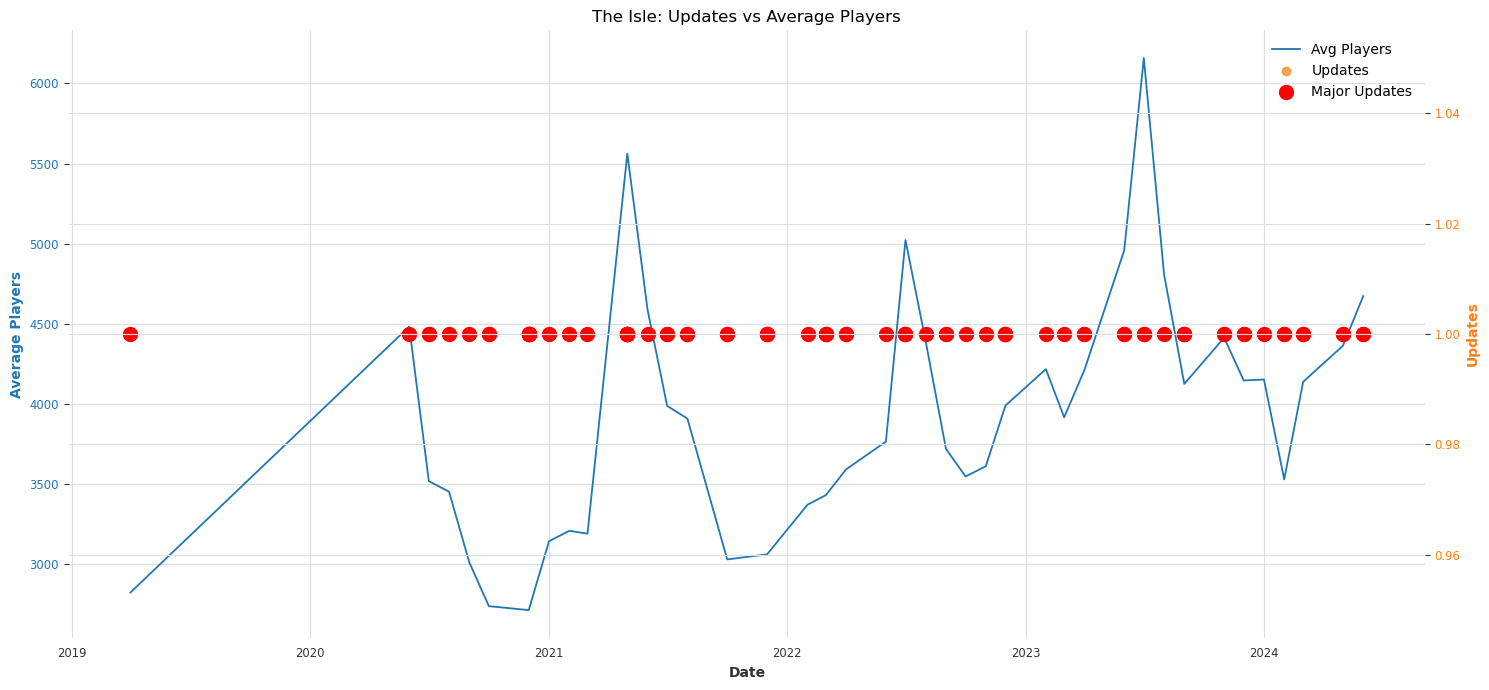

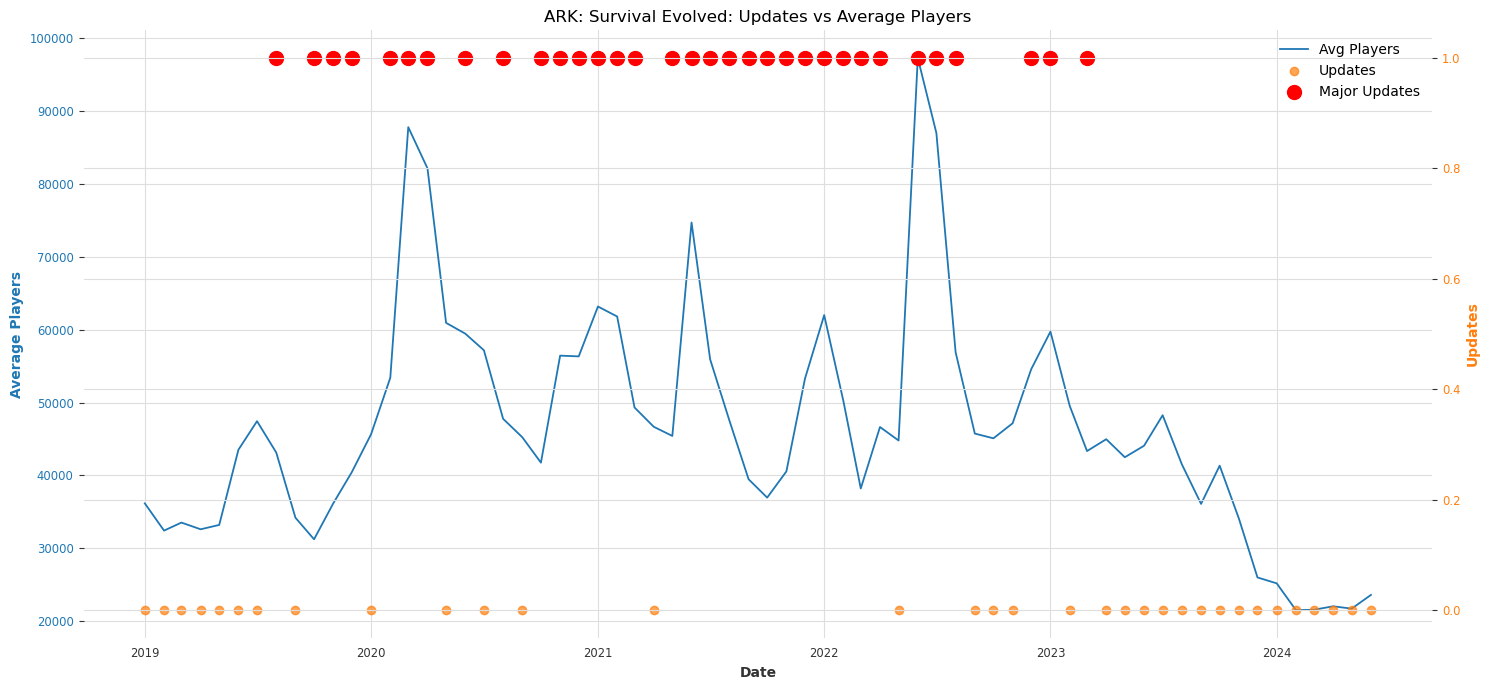

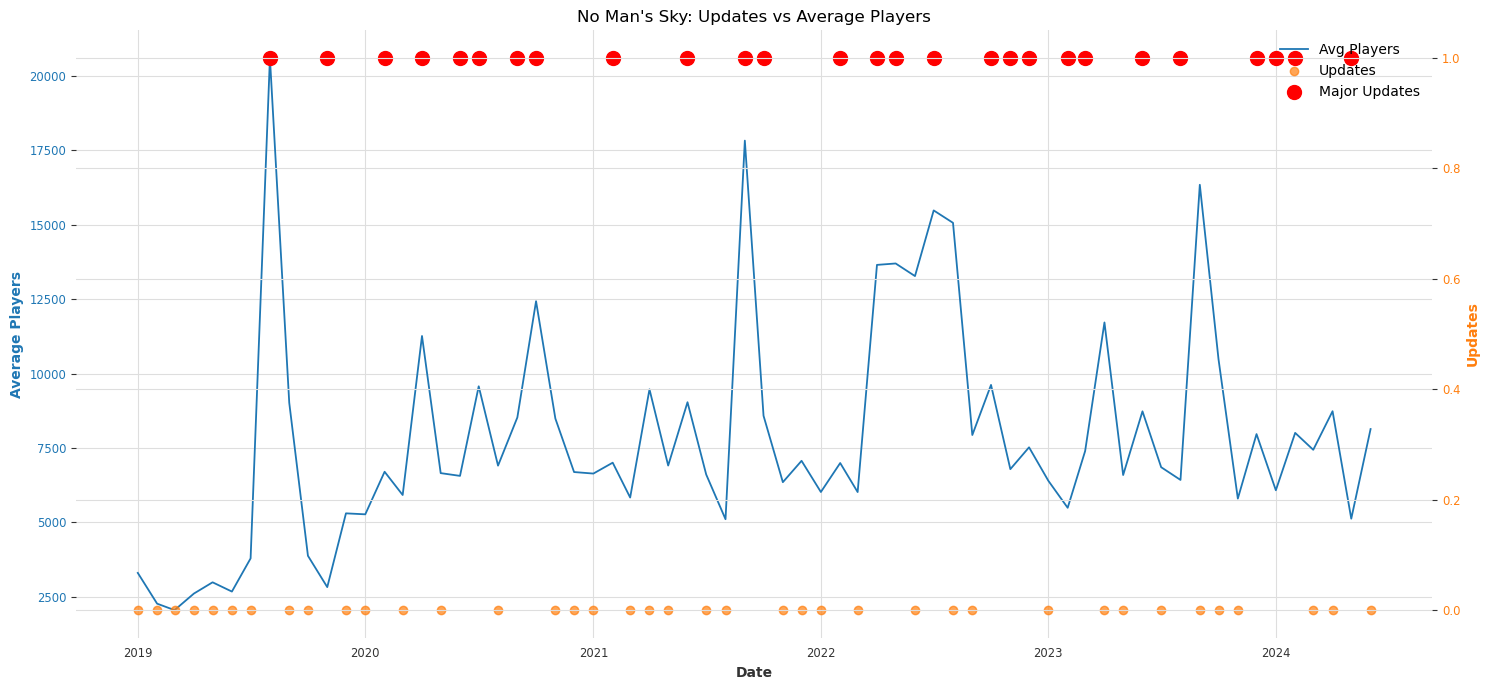

In [20]:
plot_updates_vs_players(isle_data, 'The Isle')
plot_updates_vs_players(ark_data, 'ARK: Survival Evolved')
plot_updates_vs_players(nms_data, 'No Man\'s Sky')

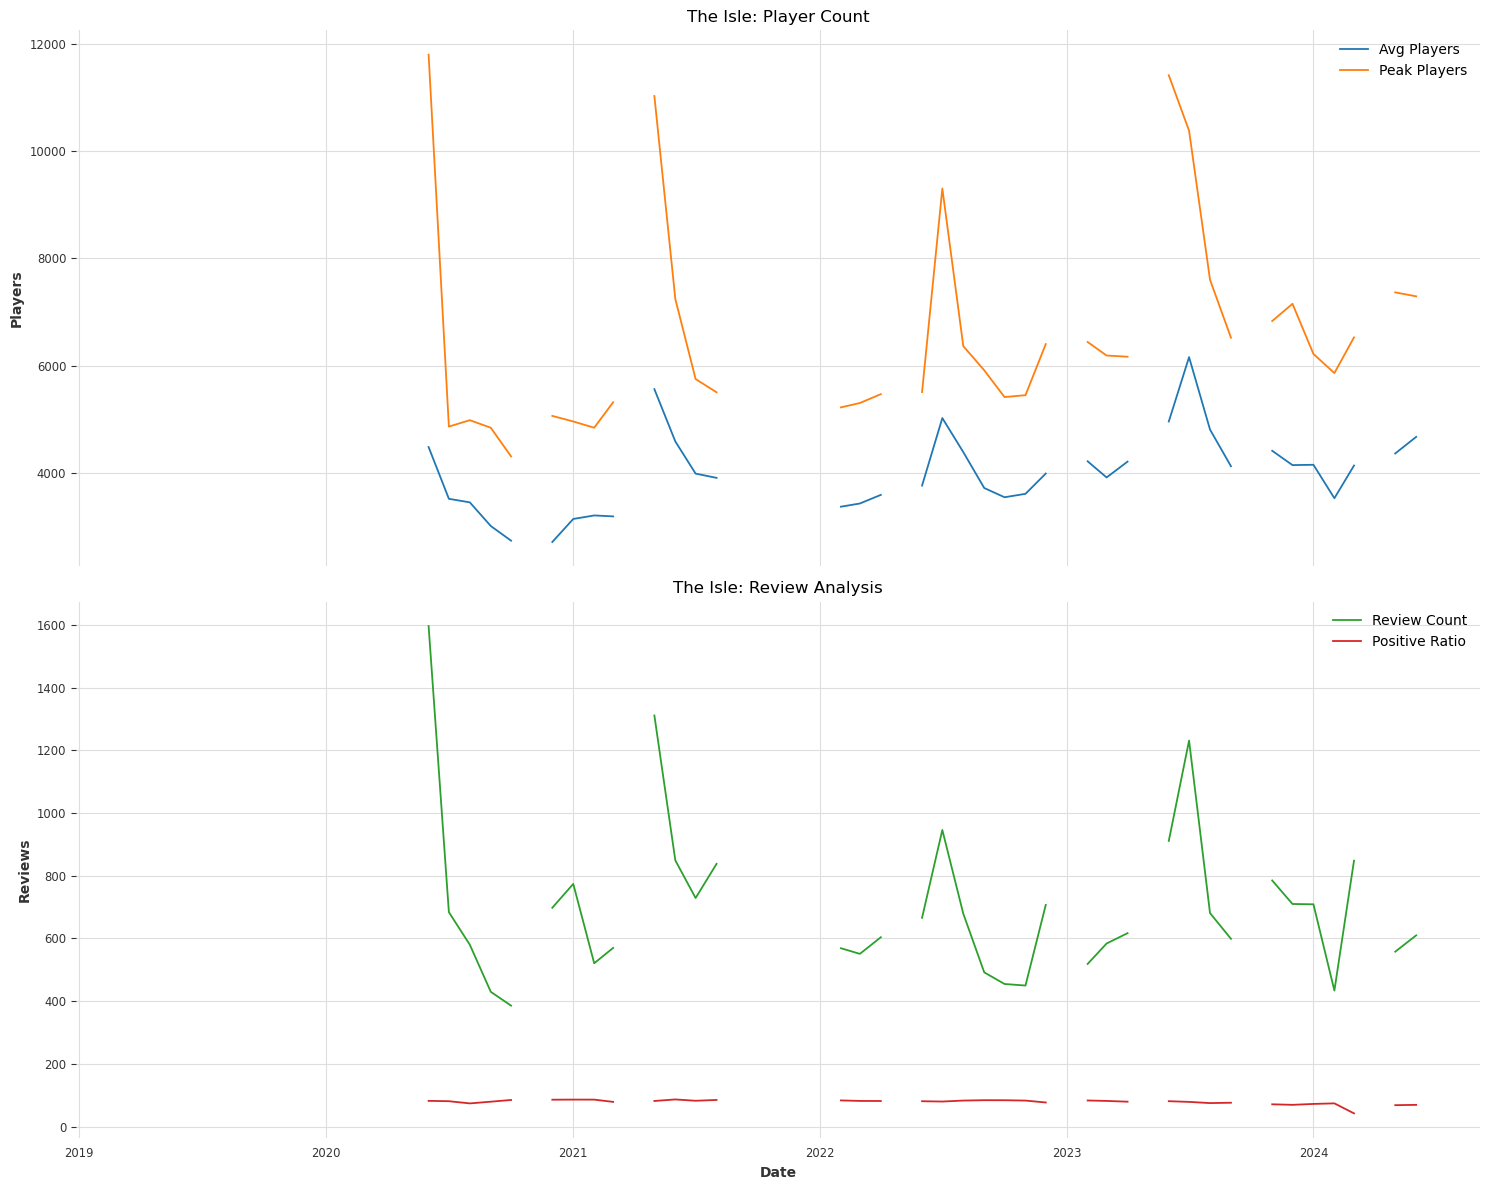

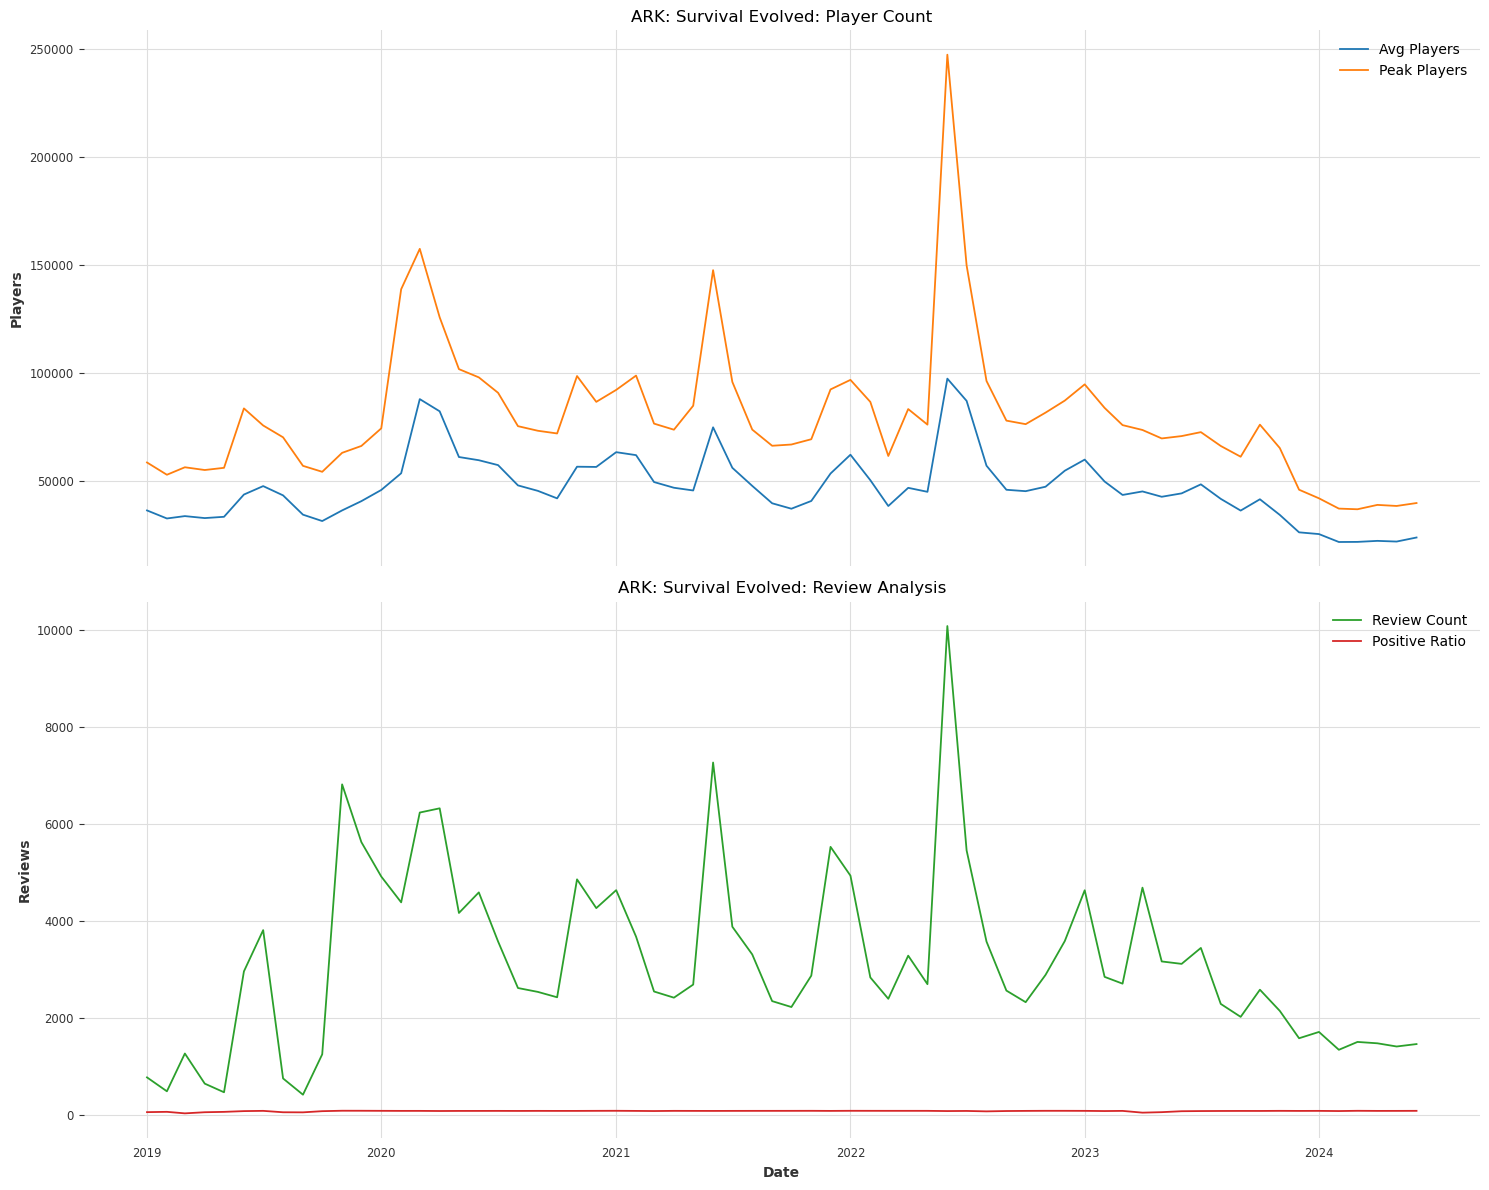

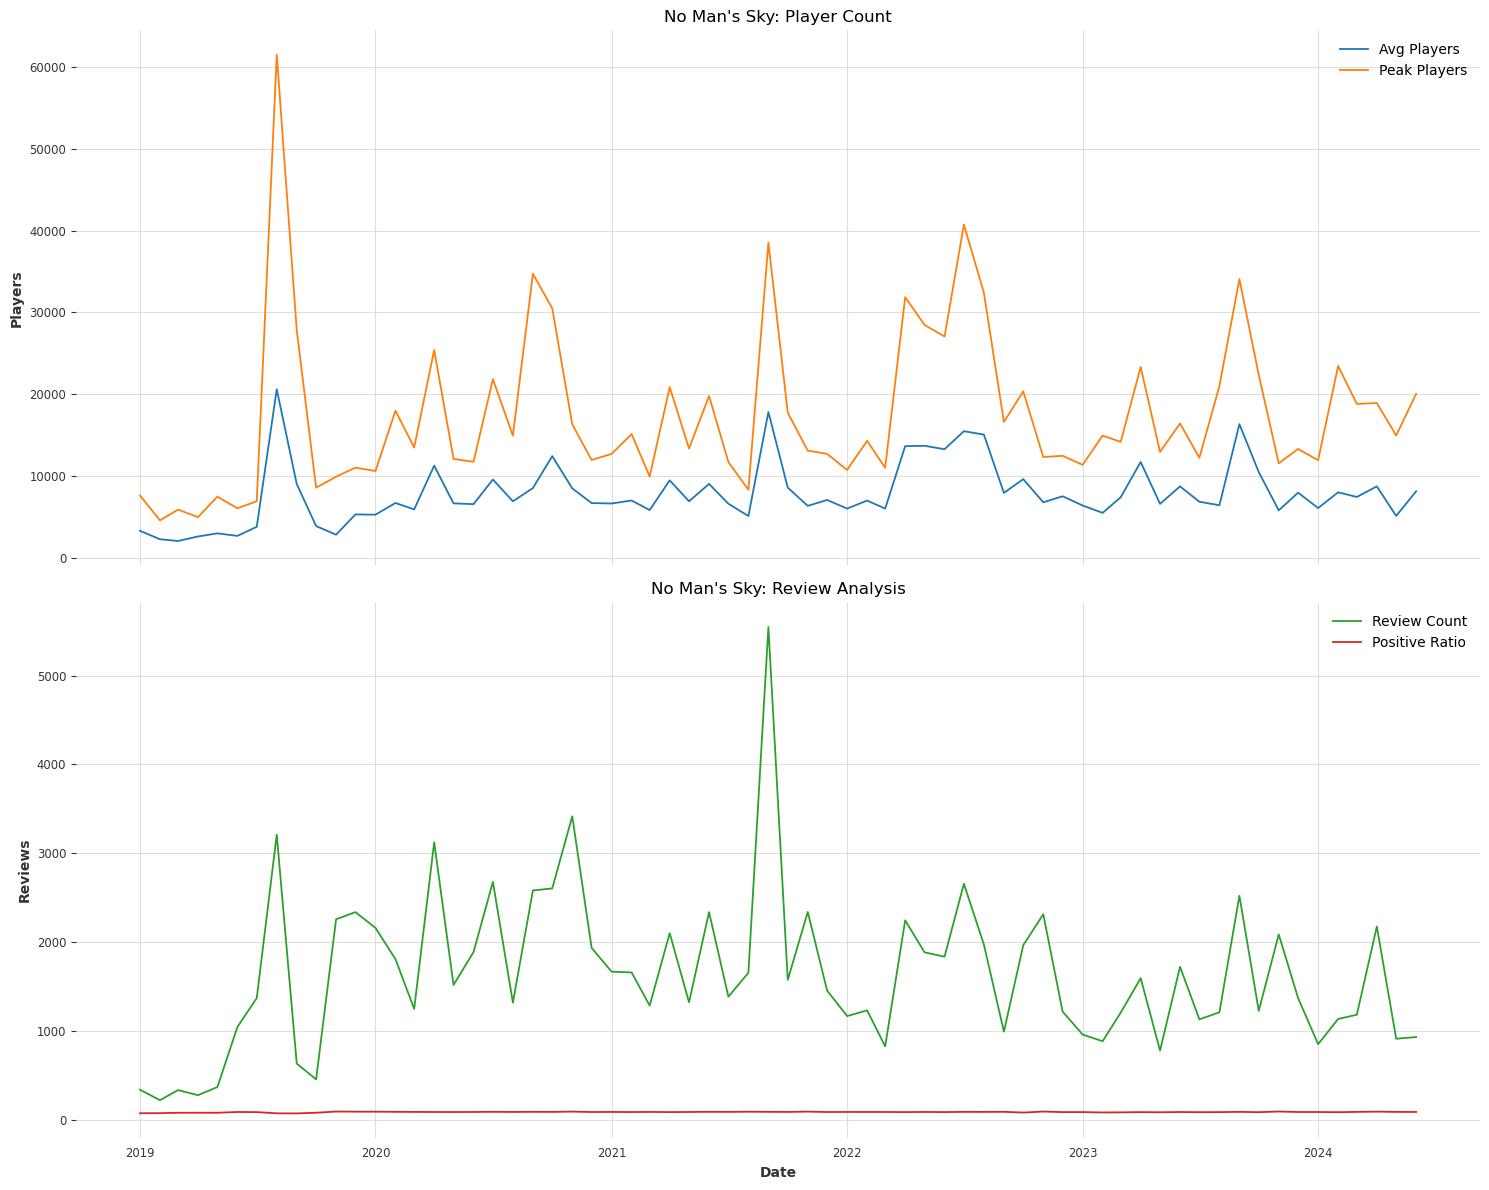

In [13]:
plot_players_and_reviews(isle_series, 'The Isle')
plot_players_and_reviews(ark_series, 'ARK: Survival Evolved')
plot_players_and_reviews(nms_series, 'No Man\'s Sky')

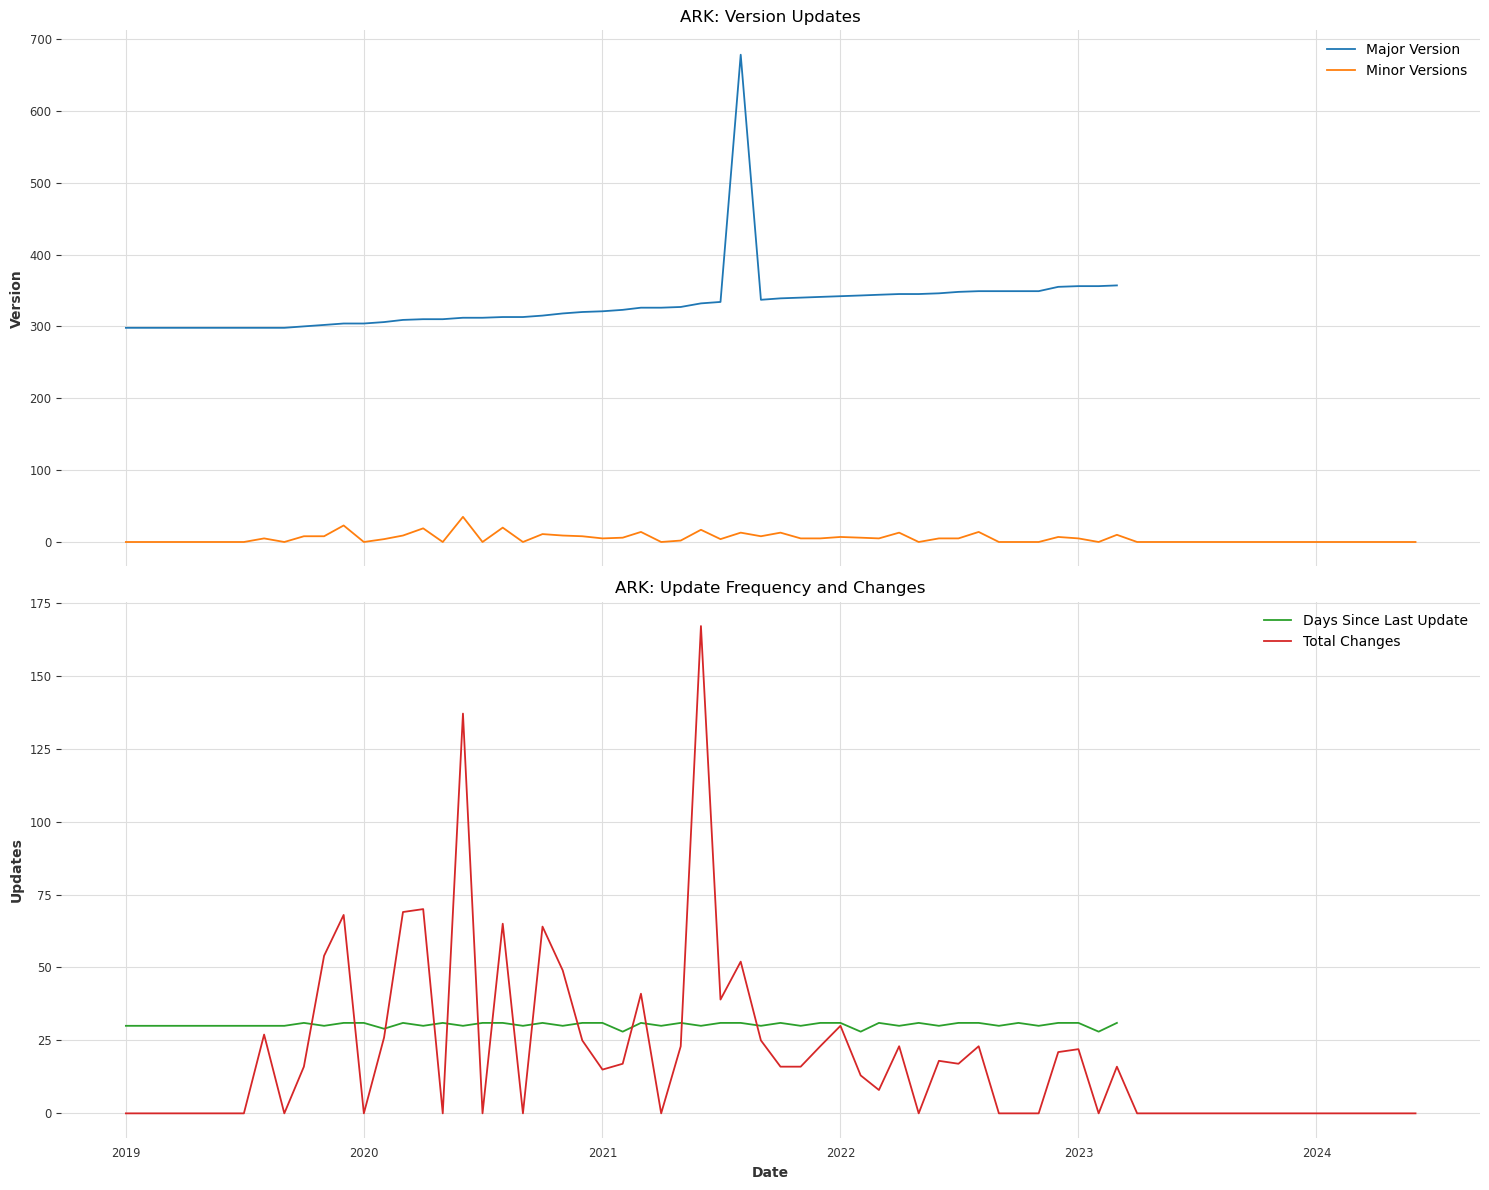

In [14]:
plot_ark_updates(ark_series)

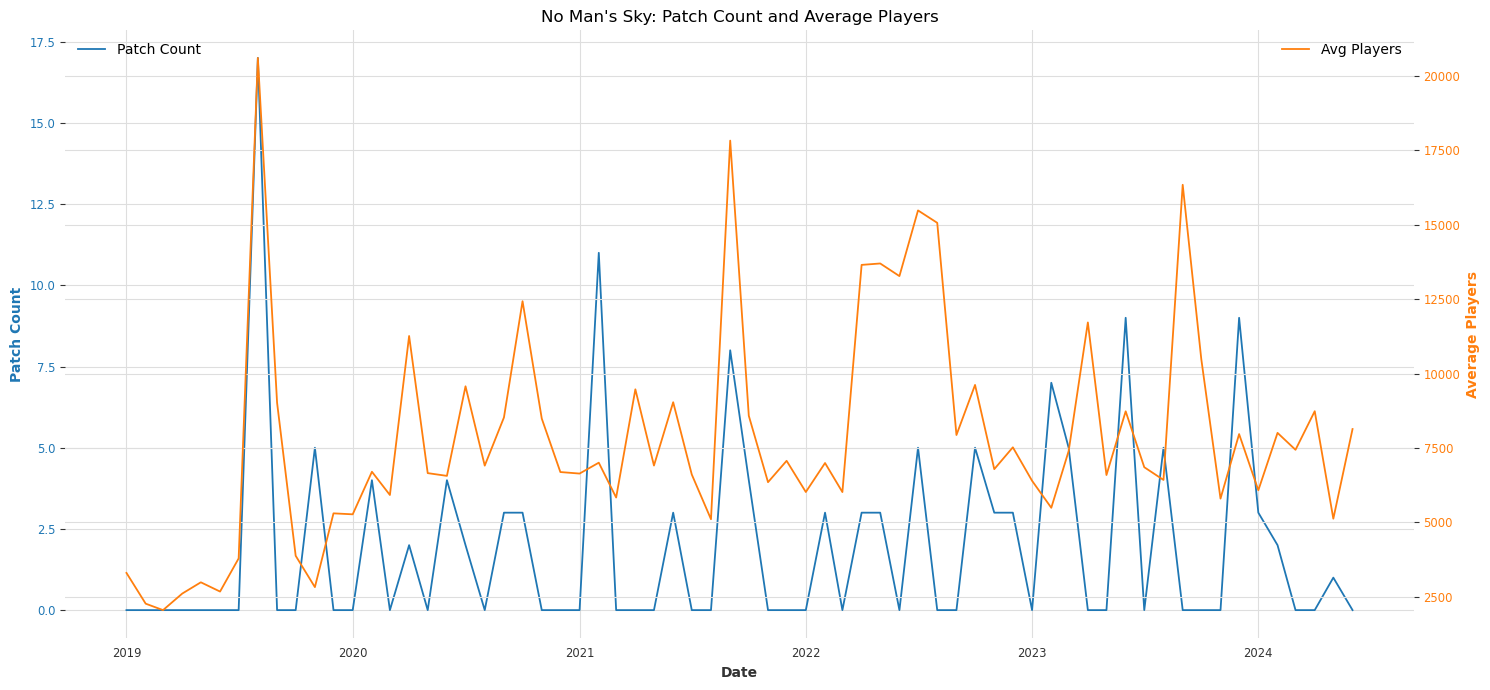

In [15]:
plot_nms_patches(nms_series)

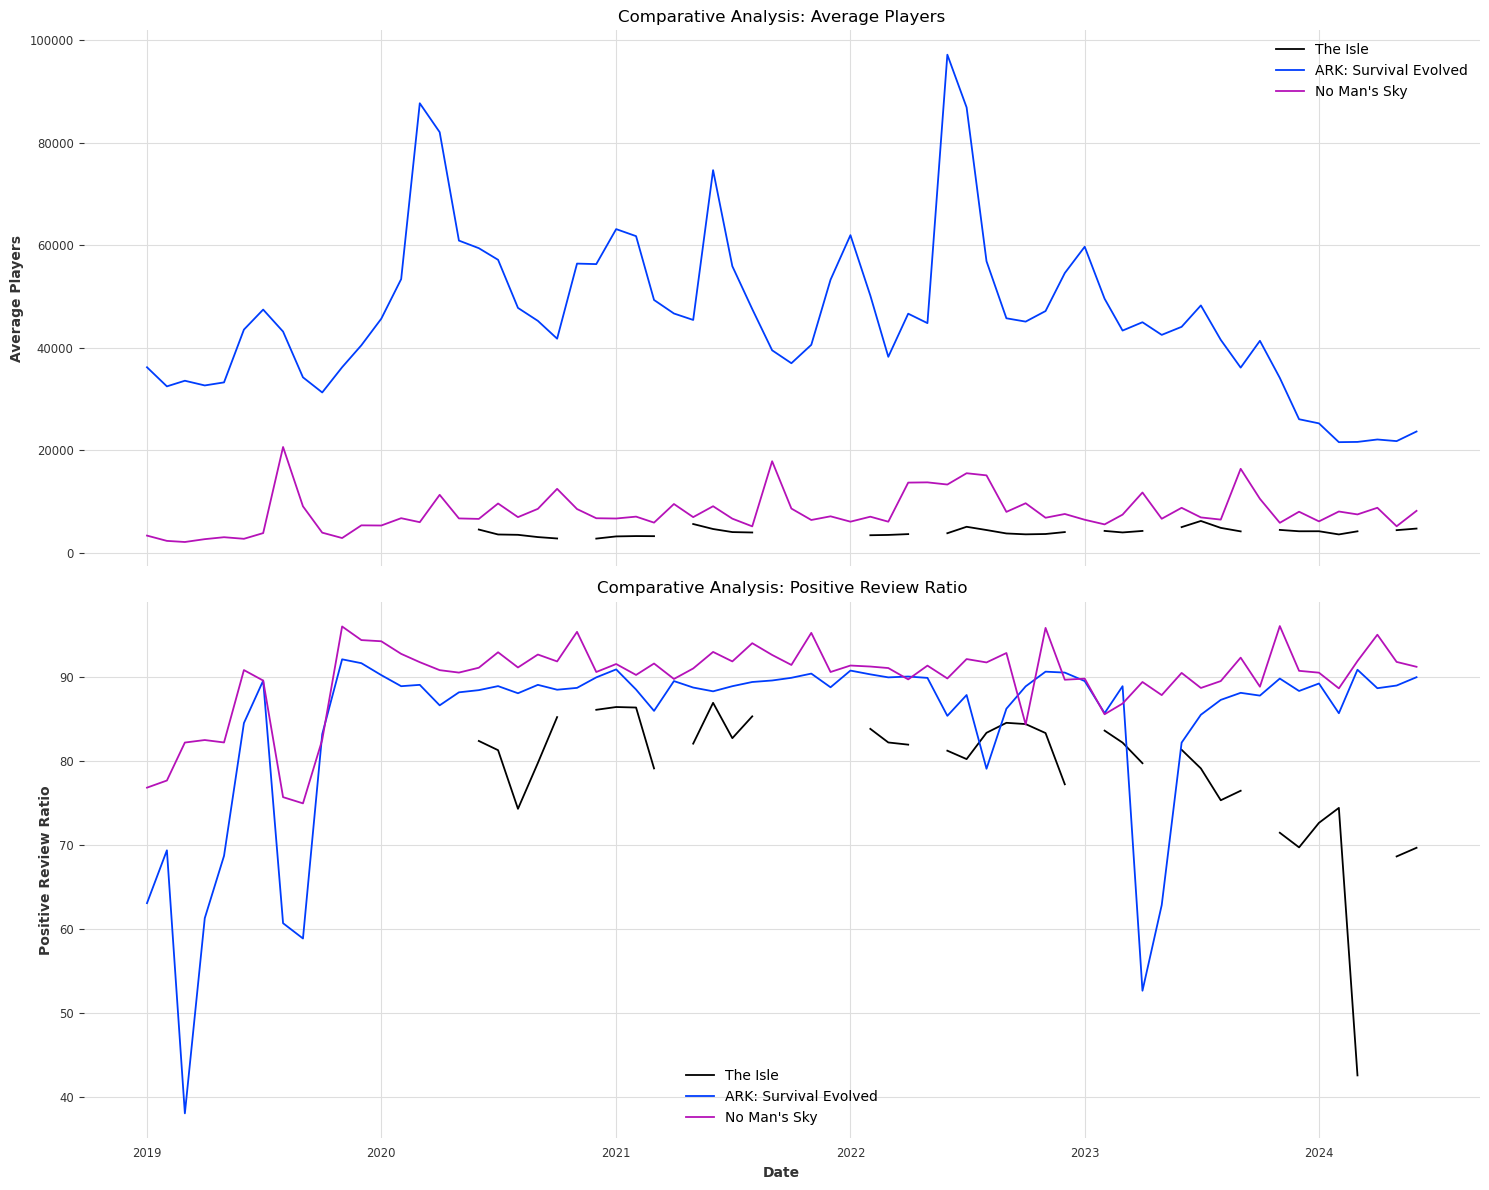

In [16]:
plot_comparative_analysis(isle_series, ark_series, nms_series)